In [2]:
pip install face_recognition

     |████████████████████████████████| 100.2MB 1.5MB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566176 sha256=aaf920a75beaba9e83e622df14844c6ff47cabed8c13fb61f45cb21ac3fe0ceb
  Stored in directory: /root/.cache/pip/wheels/d2/99/18/59c6c8f01e39810415c0e63f5bede7d83dfb0ffc039865465f
Successfully built face-recognition-models


In [3]:
import numpy as np
import cv2 as cv
import face_recognition as fr
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.spatial.distance import euclidean
from keras.models import model_from_json

Using TensorFlow backend.


In [ ]:
# Đọc ảnh đầu vào
img = cv.imread('2.jpg', 1)

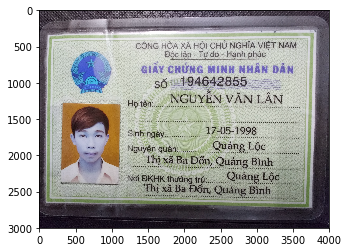

In [7]:
# Hiện ảnh đầu vào 
plt.imshow(img)
plt.show()

**Tiêu chuẩn ảnh chân dung**
* Ảnh màu. 
* Kích thước 3x4 cm. 
* Đầu để trần.
* Chụp ảnh chính diện, rõ mặt, rõ hai tai, không đeo kính, trang phục tác phong nghiêm túc, lịch sự.

In [ ]:
# Kiểm tra ảnh đầu vào có phải là ảnh màu
# True: ảnh màu
# False: ảnh trắng đen
def check_color_image(img):
  if len(img.shape) == 3:
    return True
  else:
    return False

In [ ]:
# Kiểm tra ảnh trên CMND có chứa khuôn mặt của người
# True: có đúng 1 khuôn mặt người
# False: không có hoặc có nhiều hơn 1 khuôn mặt người
def check_human_face(img):
  if len(fr.face_locations(img, model = 'cnn')) != 1:
    return False
  else:
    return True

In [ ]:
# Kiểm tra xem khuôn mặt trong ảnh CMND có chính diện hay không (không quá lệch qua trái, phải)
# True: khuôn mặt chính diện
# False: khuôn mặt bị lệch trái, phải.
def check_face_direction(img):
  face_landmarks = fr.face_landmarks(img)
  dist_1 = euclidean(face_landmarks[0]['left_eye'][3], face_landmarks[0]['nose_bridge'][0])
  dist_2 = euclidean(face_landmarks[0]['right_eye'][0], face_landmarks[0]['nose_bridge'][0])
  
  if 0.75 <= (dist_1 / dist_2) <= 1.25:
    if 0.8 <= (face_landmarks[0]['left_eye'][3][1] / face_landmarks[0]['right_eye'][0][1]) <= 1.2:
      return True
    else:
      return False
  else:
    return False

In [ ]:
# Kiểm tra xem khuôn mặt trong ảnh CMND có nhắm mắt hay không
# True: nhắm mắt
# False: mở mắt
def check_eye_closed(img):
  face_landmarks = fr.face_landmarks(img)
  dist_1 = euclidean(face_landmarks[0]['left_eye'][1], face_landmarks[0]['left_eye'][5])
  dist_2 = euclidean(face_landmarks[0]['left_eye'][2], face_landmarks[0]['left_eye'][4])
  dist_3 = euclidean(face_landmarks[0]['left_eye'][0], face_landmarks[0]['left_eye'][3])
  
  dist_4 = euclidean(face_landmarks[0]['right_eye'][1], face_landmarks[0]['right_eye'][5])
  dist_5 = euclidean(face_landmarks[0]['right_eye'][2], face_landmarks[0]['right_eye'][4])
  dist_6 = euclidean(face_landmarks[0]['right_eye'][0], face_landmarks[0]['right_eye'][3])
  
  ear_1 = (dist_1 + dist_2) / (2 * dist_3)
  ear_2 = (dist_4 + dist_5) / (2 * dist_6)
  
  if ear_1 <= 0.3 or ear_2 <= 0.3:
    return True
  else:
    return False

In [ ]:
# Kiểm tra xem khuôn mặt trong ảnh CMND có hé môi (mở miệng) hay không
# True: hé môi
# False: không hé môi
def check_lip_opened(img):
  face_landmarks = fr.face_landmarks(img)
  if 0.97 <= face_landmarks[0]['top_lip'][-4][1] / face_landmarks[0]['bottom_lip'][-4][1] <= 1.07:
    return False
  else:
    return True

In [ ]:
# Kiểm tra khuôn mặt trong ảnh CMND có khớp với khuôn mặt của khách hàng
# True: khớp
# False: không khớp
def check_matched_faces(real_img, card_img):
  real_img_encoding = fr.face_encodings(real_img)[0]
  card_img_encoding = fr.face_encodings(card_img)[0]
  
  return fr.compare_faces([real_img_encoding], card_img_encoding)[0]

In [ ]:
# Kiểm tra khuôn mặt trong ảnh CMND có đeo kính
# True: đeo kính
# False: không đeo kính
def check_eyeglasses(img):
  img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  img = cv.GaussianBlur(img, (11, 11), 0)

  sobel_y = cv.Sobel(img, cv.CV_64F, 0, 1, ksize=-1)
  sobel_y = cv.convertScaleAbs(sobel_y)
  edgeness = sobel_y
    
  retVal,thresh = cv.threshold(edgeness, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

  d = len(thresh) * 0.5
  x = np.int32(d * 6/7)
  y = np.int32(d * 3/4)
  w = np.int32(d * 2/7)
  h = np.int32(d * 2/4)

  x_2_1 = np.int32(d * 1/4)
  x_2_2 = np.int32(d * 5/4)
  w_2 = np.int32(d * 1/2)
  y_2 = np.int32(d * 8/7)
  h_2 = np.int32(d * 1/2)
    
  roi_1 = thresh[y:y+h, x:x+w] 
  roi_2_1 = thresh[y_2:y_2 + h_2, x_2_1:x_2_1 + w_2]
  roi_2_2 = thresh[y_2:y_2 + h_2, x_2_2:x_2_2 + w_2]
  roi_2 = np.hstack([roi_2_1, roi_2_2])
    
  measure_1 = sum(sum(roi_1/255)) / (np.shape(roi_1)[0] * np.shape(roi_1)[1])
  measure_2 = sum(sum(roi_2/255)) / (np.shape(roi_2)[0] * np.shape(roi_2)[1])
  measure = measure_1 * 0.3 + measure_2 * 0.7
    
  if measure > 0.15:
    return True
  else:
    return False

In [ ]:
# 0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'
def check_emotion(img):
  
  json_file = open('fer.json', 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  classifier = model_from_json(loaded_model_json)
  classifier.load_weights("fer.h5")
  
  face = fr.face_locations(img, model = 'cnn')[0]
  top, right, bottom, left = face
  
  roi = img[top: bottom, left: right]
  roi_gray = cv.cvtColor(roi, cv.COLOR_BGR2GRAY)
  
  cropped_img = np.expand_dims(np.expand_dims(cv.resize(roi_gray, (48, 48)), -1), 0)
  cv.normalize(cropped_img, cropped_img, alpha = 0, beta = 1, norm_type = cv.NORM_L2, dtype = cv.CV_32F)
  
  if np.argmax(classifier.predict(cropped_img)) == 6:
    return True
  else:
    return False

In [66]:
check_emotion(img)

False

In [ ]:
check_eyeglasses(img)

False

In [ ]:
check_color_image(img)

True

In [18]:
check_human_face(img)

True

In [ ]:
real_img = cv.imread('Chanyeol 1.png', 1)
card_img = cv.imread('Chanyeol 2.jpg', 1)
check_matched_faces(real_img, card_img)

True

In [32]:
check_face_direction(img)

False

In [ ]:
check_eye_closed(img)

False

In [45]:
# Hàm này không sử dụng
from PIL import Image, ImageDraw
import face_recognition

# Load the jpg file into a numpy array
image = face_recognition.load_image_file("2.jpg")
top, right, bottom, left = face_recognition.face_locations(image, model = 'cnn')[0]

img = image[top: bottom, left: right]
'''
#img = image

# Find all facial features in all the faces in the image
face_landmarks_list = face_recognition.face_landmarks(img)

print("I found {} face(s) in this photograph.".format(len(face_landmarks_list)))

# Create a PIL imagedraw object so we can draw on the picture
pil_image = Image.fromarray(img)
d = ImageDraw.Draw(pil_image)

for face_landmarks in face_landmarks_list:
  
  # Print the location of each facial feature in this image
  for facial_feature in face_landmarks.keys():
    print("The {} in this face has the following points: {}".format(facial_feature, face_landmarks[facial_feature]))

  # Let's trace out each facial feature in the image with a line!
  for facial_feature in face_landmarks.keys():
    d.line(face_landmarks[facial_feature], width=5)

# Show the picture
pil_image.show()
plt.imshow(pil_image)
plt.show()'''

(507, 507, 3)


'\n#img = image\n\n# Find all facial features in all the faces in the image\nface_landmarks_list = face_recognition.face_landmarks(img)\n\nprint("I found {} face(s) in this photograph.".format(len(face_landmarks_list)))\n\n# Create a PIL imagedraw object so we can draw on the picture\npil_image = Image.fromarray(img)\nd = ImageDraw.Draw(pil_image)\n\nfor face_landmarks in face_landmarks_list:\n  \n  # Print the location of each facial feature in this image\n  for facial_feature in face_landmarks.keys():\n    print("The {} in this face has the following points: {}".format(facial_feature, face_landmarks[facial_feature]))\n\n  # Let\'s trace out each facial feature in the image with a line!\n  for facial_feature in face_landmarks.keys():\n    d.line(face_landmarks[facial_feature], width=5)\n\n# Show the picture\npil_image.show()\nplt.imshow(pil_image)\nplt.show()'

In [ ]:
# Hàn này không sử dụng
def calculate(img):
  face_landmarks = fr.face_landmarks(img)
  dist_1 = euclidean(face_landmarks[0]['left_eye'][3], face_landmarks[0]['nose_bridge'][0])
  dist_2 = euclidean(face_landmarks[0]['right_eye'][0], face_landmarks[0]['nose_bridge'][0])
  
  print(dist_1 / dist_2)

In [46]:
calculate(img)

1.2013872173809792
